In [1]:
import string
import pandas as pd
import numpy as np
import requests
import unidecode
import re


def try_download_json(url:str) -> pd.DataFrame:

    try:
        response = requests.get(url)
        data = response.json()
        return pd.DataFrame(data)

    except:
        print(f"Erreur de chargement du lien - {url}")
        quit()


def clean_data(df:pd.DataFrame) -> pd.DataFrame:

    liste_salaires = df['lieu'].apply(lambda x : x[1] if len(x) > 1 else '')

    df['lieu'] = df['lieu'].apply(lambda x : unidecode.unidecode(x[0]))

    df['Nom de la société'] = df['Type de poste'].apply(lambda x : x[2] if len(x) > 2 else '')
    df['Type de contrat'] = df['Type de poste'].apply(lambda x : x[7].split(' - ')[0] if len(x) > 7 else '')
    df.drop(columns='Type de poste', inplace=True)

    df = df.apply(lambda c : c.apply(lambda x : ','.join([s.strip("\n ").lower() for s in (x.split(',') if type(x) != list else x)])))

    liste_dates = df['Date de publication'].apply(lambda x: '0 j' if x.find('heures') != -1 else x.removeprefix('postée il y a ').replace('postée hier', '1 j').strip('iorsu'))

    df['Date de publication'] = pd.to_datetime(liste_dates.apply(
        lambda x :
            pd.to_datetime("2023-01-15") - (pd.DateOffset(months=int(x.split()[0])) if x.split()[1] == 'm' else pd.DateOffset(days=int(x.split()[0])))
        ))

    df['Salaire minimum'] = liste_salaires.apply(lambda x : float(x.split(' - ')[0].strip(' €\n').replace('.', '').replace(',', '.')) if x != '' else np.nan)
    df['Salaire maximum'] = liste_salaires.apply(lambda x : float(x.split(' - ')[1].strip(' €/an\n' + string.ascii_letters).replace('.', '').replace(',', '.')) if x != '' else np.nan)

    noms_ville = ['la defense', 'guyancourt', 'antony', 'paris']

    df['lieu'] = df['lieu'].apply(
        lambda x :
            ([n for n in noms_ville for i in x.replace(' - ', ',').replace('-', ' ').split(',') if n in i] + [x.replace('-', ' ')])[0]
        )

    #remplace si data analyst dans vavlue par data analyste etc
    terms_to_replace = {'analyst': 'data analyst', 'datascientist': 'data scientist', 'data engineer': 'ingénieur','conultant/analyste': 'consultant/analyste','2018788': '',
                        'developer': 'developpeur','full stacke': 'developpeur','global technical seo manager': 'manager','engineer': 'ingenieur','lead': 'chef','full': 'developpeur','ingénieur': 'ingenieur','analyste': 'data analyst','product': 'chef de projet'}
    df["Intitulé du poste"] = df["Intitulé du poste"].apply(lambda x: ' '.join([terms_to_replace.get(term, term) for term in unidecode.unidecode(x).split()]))

    keywords = ["stage","business analyst","analyste fonctionnel","architecte","apprenti","data ingenieur","data ingénieur", "data engineer","data analyst","data scientist","consultant","ingenieur","chef de projet","concepteur","alternance",
                "technical leader","technicien","responsable","référent","expert","developpeur","specialiste","referent","manager","postdoctorant","internship"]

    for keyword in keywords:
        df["Intitulé du poste"] = df["Intitulé du poste"].str.replace(rf"(.*{keyword})", keyword, regex=True)
        df["Intitulé du poste"] = df["Intitulé du poste"].str.replace(rf"({keyword}.*)", keyword, regex=True)

    df['Intitulé du poste'] = df['Intitulé du poste'].apply(lambda x: re.sub(r'[hf]/[hf]|[-\/()]', '', x))

    return df


def main():

    url = "https://raw.githubusercontent.com/Lorenzo1208/Projet_TrouveTonJob/main/data.json"

    df = try_download_json(url)
    df = clean_data(df)

    df.to_csv("data_clean.csv")


if __name__ == '__main__':
    main()

In [2]:
df = pd.read_csv("data_clean.csv")
df = df.dropna(subset=["competences"])
df = df[df["competences"] != ""]
df["competences"] = df["competences"].str.split(",")
df_exploded = df.explode('competences')
df["competences"]


0                                [sql, t-sql, outils]
1          [support, outils, agile, design, big data]
2               [crm, data quality, sql, sas, python]
3                                  [si, support, sap]
4           [outils, support, decisionnel, sql, test]
                            ...                      
225          [sap, abap, progiciel, système, support]
226      [digital, outils, securité, sécurité, t-sql]
227              [test, serveur, jquery, mobile, tdd]
228      [nosql, unix, java, machine learning, linux]
229    [big data, support, python, réseaux, securité]
Name: competences, Length: 229, dtype: object

In [3]:
competences_count = df_exploded["competences"].value_counts()
top_5_competences = competences_count.nlargest(5)
top_5_competences = top_5_competences.index
print(top_5_competences)

Index(['outils', 'support', 'si', 'big data', 'securité'], dtype='object')


In [4]:
unique_types = df["Type de contrat"].unique()
unique_types = unique_types[~pd.isna(unique_types)]
print(unique_types)

['cdi' 'cdd/intérim' 'stage' 'contrat de professionnalisation'
 "contrat d'apprentissage"]


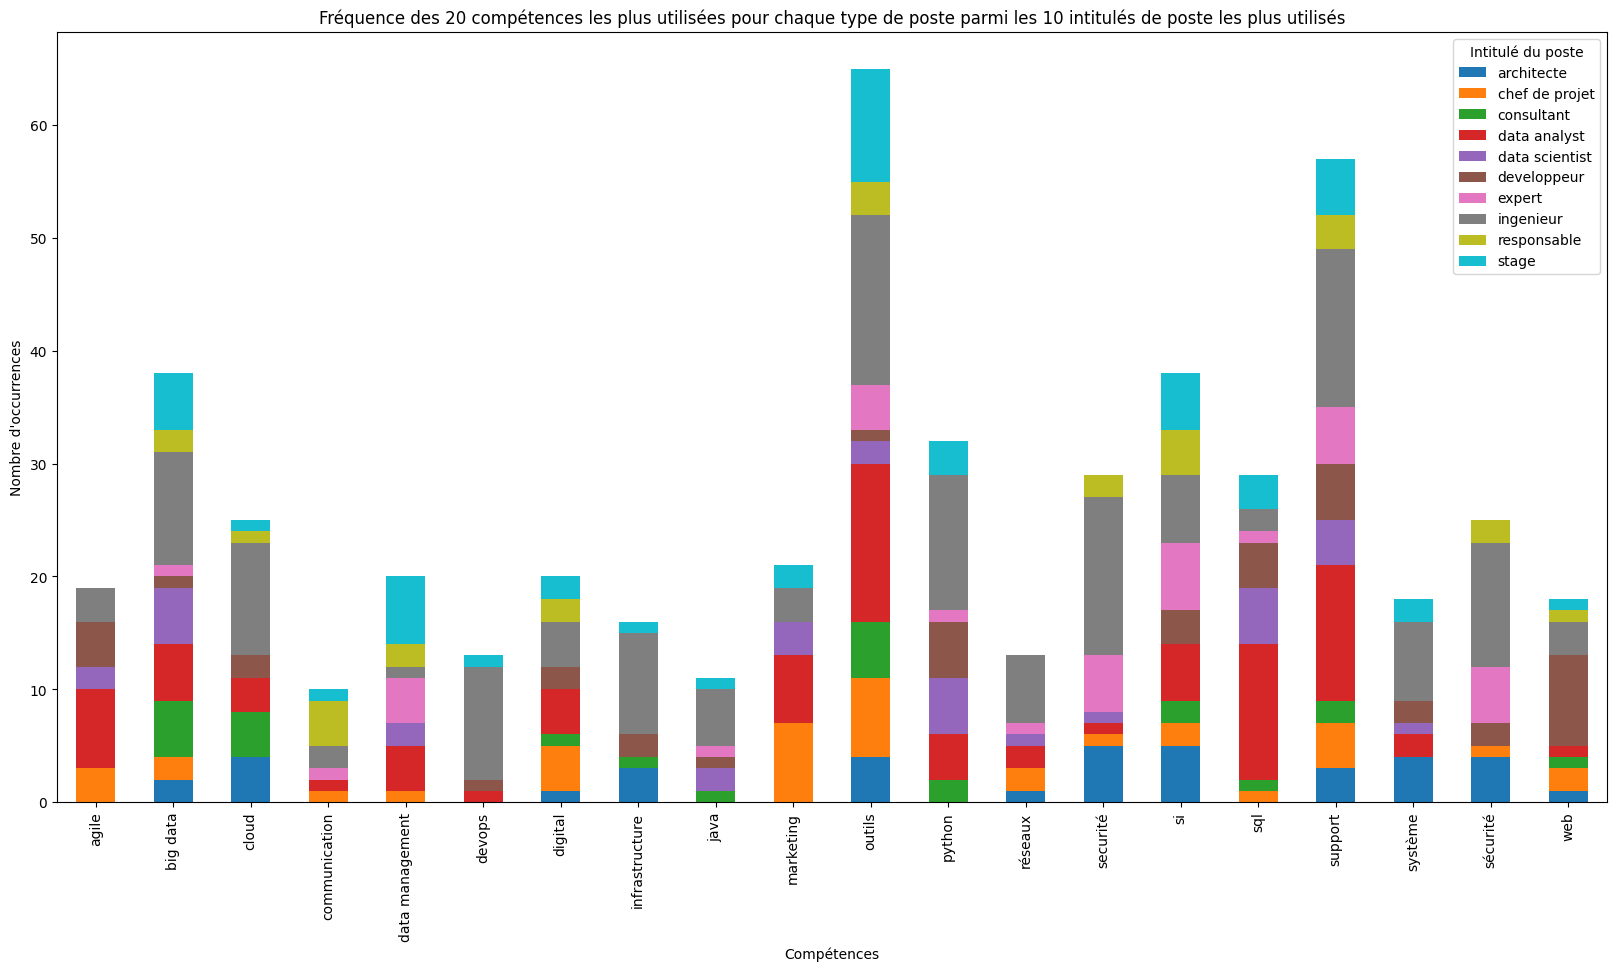

In [6]:
import matplotlib.pyplot as plt

df = pd.read_csv("data_clean.csv")
df = df.dropna(subset=["competences"])
df = df[df["competences"] != ""]
df["competences"] = df["competences"].str.split(",")
df_exploded = df.explode('competences')
competences_count = df_exploded["competences"].value_counts()
top_20_competences = competences_count.nlargest(20)
top_20_competences = top_20_competences.index
job_title_count = df['Intitulé du poste'].value_counts()
top_10_job_titles = job_title_count.nlargest(10)
top_10_job_titles = top_10_job_titles.index
df_filtered = df_exploded[df_exploded["Intitulé du poste"].isin(top_10_job_titles)]
df_filtered = df_filtered[df_filtered["competences"].isin(top_20_competences)]
competences_count = df_filtered.groupby(["Intitulé du poste", "competences"]).size().reset_index(name="count")
competences_count = competences_count.pivot(index='competences', columns='Intitulé du poste', values='count')
competences_count.plot(kind="bar", stacked=True, figsize=(20, 10))
plt.xlabel("Compétences")
plt.ylabel("Nombre d'occurrences")
plt.title("Fréquence des 20 compétences les plus utilisées pour chaque type de poste parmi les 10 intitulés de poste les plus utilisés")
plt.show()
#